In [1]:
import sys
import sklearn
import matplotlib
import numpy as np
from datetime import datetime

from scipy import optimize
from numpy import log, exp
    
from scipy.stats import multivariate_normal as mnorm
from scipy.stats import norm

import matplotlib.pyplot as plt

# python magic function
%matplotlib inline

print('Python: {}'.format(sys.version))
print('Sklearn: {}'.format(sklearn.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('NumPy: {}'.format(np.__version__))

Python: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Sklearn: 0.23.2
Matplotlib: 3.3.2
NumPy: 1.19.2


In [2]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

print('Training Data: {}'.format(X_train.shape))
print('Training Labels: {}'.format(y_train.shape))
print('Testing Data: {}'.format(X_test.shape))
print('Testing Labels: {}'.format(y_test.shape))

Training Data: (60000, 28, 28)
Training Labels: (60000,)
Testing Data: (10000, 28, 28)
Testing Labels: (10000,)


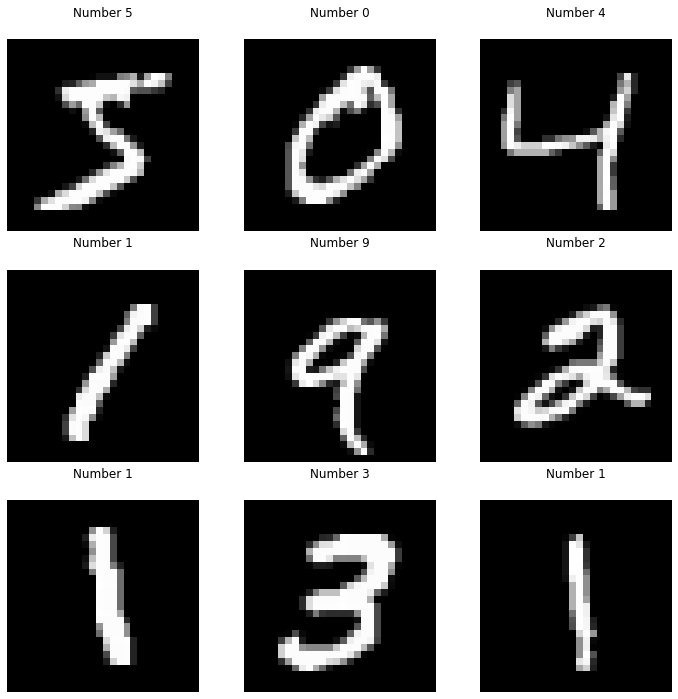

In [4]:
# create figure with 3x3 subplots using matplotlib.pyplot
fig, axs = plt.subplots(3, 3, figsize = (12, 12))
plt.gray()

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
    ax.matshow(X_train[i])
    ax.axis('off')
    ax.set_title('Number {}'.format(y_train[i]))
    
# display the figure
fig.show()

In [5]:
# preprocessing the images

# convert each image to 1 dimensional array
X_train = X_train.reshape(len(X_train),-1)
X_test = X_test.reshape(len(X_test),-1)
# y_test = y_test

# normalize the data to 0 - 1
X_train = X_train.astype(float) / 255.
X_test = X_test.astype(float) / 255.

y_classes = set(y_train)

print(X_train.shape)
print(X_train[0].shape)
print(X_test.shape)
print(X_test[0].shape)
print(y_train.shape)
print(y_test.shape)
print(f'Y Class Labels: {y_classes}')

(60000, 784)
(784,)
(10000, 784)
(784,)
(60000,)
(10000,)
Y Class Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [6]:
# using an optimizer
def negloglike(theta, x):
    mu = theta[0]
    var = theta[1]
    
    # setup lower bound for the variance
    limit = 1e-6    
    if var < limit:
        var = limit
        
    N = x.size
    nll = N*log(var) + np.sum((x - mu)**2/var)
    return nll

# fit to create a normal probability distribution for a feature data (one column)
def fit_distribution(x):
    feature_mean = np.mean(x)
    feature_var = np.var(x)
    
    bnds = ((None, None), (0, None))
    
    params = optimize.minimize(negloglike, np.array([feature_mean, feature_var]), 
                               args=(x), bounds=bnds, tol=1e-10, method='BFGS')
    
    opt_mean = params.x[0]
    opt_std = np.sqrt(params.x[1]) # convert variance to std dev
    
    dist = norm(opt_mean, opt_std)
    
    return dist

# this function calculates the mle = likelihood
def mle_prob(X, col_dist_list):
    # feature_1 * feature_2 * .. * feature_N
#     print(X.shape)
    acc_prob = 1
    for i in range(X.shape[0]):
        dist = col_dist_list[i]
        prob = dist.pdf(X[i])
        if np.isnan(prob):
            prob = 1
        acc_prob *= prob
    return acc_prob

# this function calculates the posterior = likelihood * prior
def map_prob(X, col_dist_list, prior):
    # feature_1 * feature_2 * .. * feature_N * prior
    acc_prob = 1
    for i in range(X.shape[0]):
        dist = col_dist_list[i]
        prob = dist.pdf(X[i])
        if np.isnan(prob):
            prob = 1
        acc_prob *= prob
    return acc_prob * prior

In [7]:
X_subsets = []
for cls in y_classes:
    print(f'Processing Y Class: {cls}')
#     this_x = X[y==cls]
    X_subsets.append(X_train[y_train==cls])
X_subsets = np.asarray(X_subsets)
print(X_subsets.shape)

Processing Y Class: 0
Processing Y Class: 1
Processing Y Class: 2
Processing Y Class: 3
Processing Y Class: 4
Processing Y Class: 5
Processing Y Class: 6
Processing Y Class: 7
Processing Y Class: 8
Processing Y Class: 9
(10,)


In [8]:
start_time = datetime.now()

cls_col_dist_list = []
for cls in y_classes:
    # OK, since y classes are 0 and 1, so use it as the index
    print(f'Processing Y Class: {cls}')
    x_subset = X_subsets[cls]
    print(x_subset.shape)
    
    # For each column, create a normal distribution and put in the list
    col_dist_list = np.array([fit_distribution(x_subset[:, i]) for i in range(x_subset.shape[1])])
    cls_col_dist_list.append(col_dist_list)
cls_col_dist_list = np.array(cls_col_dist_list)
cls_col_dist_list.shape

end_time = datetime.now()

print(f'Runtime: {str(end_time-start_time)}')

Processing Y Class: 0
(5923, 784)
Processing Y Class: 1
(6742, 784)
Processing Y Class: 2
(5958, 784)
Processing Y Class: 3
(6131, 784)
Processing Y Class: 4
(5842, 784)
Processing Y Class: 5
(5421, 784)
Processing Y Class: 6
(5918, 784)
Processing Y Class: 7
(6265, 784)
Processing Y Class: 8
(5851, 784)
Processing Y Class: 9
(5949, 784)
Runtime: 0:01:27.098300


In [9]:
prior_list = np.array([len(X_subsets[cls]) / len(X_train) for cls in y_classes])
prior_list

array([0.09871667, 0.11236667, 0.0993    , 0.10218333, 0.09736667,
       0.09035   , 0.09863333, 0.10441667, 0.09751667, 0.09915   ])

In [14]:
# try to classify sample
y_pred = []
y_test_list = []
# for i in range(len(X)):
for i in range(500):
    sample_index = i
#     x_t, y_t = X[i], y[i]
    x_t, y_t = X_test[i], y_test[i]
#     print(X_test, y_test)
    
    # calculate the probability of p(y=0|x)
    # for each class, calculate the probability
    post_prob = [mle_prob(x_t, cls_col_dist_list[cls]) for cls in y_classes]
#     print(post_prob)

    y_pred.append(np.argmax(post_prob))
    y_test_list.append(y_t)    


In [15]:
y_pred = np.asarray(y_pred)
y_test_list = np.asarray(y_test_list)

print(y_pred)
print(y_test_list)

[7 2 1 0 4 1 4 9 4 7 0 6 9 0 1 3 9 7 2 4 9 6 6 5 4 0 7 4 0 1 3 1 3 0 7 2 7
 1 2 1 1 7 4 2 3 3 3 6 4 4 6 3 5 3 6 0 4 1 9 4 7 2 7 2 7 1 2 4 3 0 7 0 2 7
 1 7 3 2 1 7 7 6 2 7 4 4 7 3 6 1 3 6 1 3 1 4 1 2 6 9 6 0 5 4 9 9 2 1 9 4 1
 1 1 9 7 4 4 4 7 4 3 4 7 6 7 9 0 5 8 5 6 6 3 2 1 1 0 1 6 4 6 7 3 1 7 1 8 2
 0 2 4 4 5 3 1 5 6 0 3 4 4 6 5 4 6 3 4 5 1 4 4 7 2 3 2 1 1 4 1 8 1 8 1 0 3
 4 2 3 0 1 1 1 0 4 0 4 1 6 4 2 3 6 1 1 1 3 9 3 2 9 4 7 9 1 9 0 3 5 7 5 7 2
 2 7 1 2 8 1 1 7 3 1 8 7 7 7 2 2 4 1 3 3 8 4 2 3 0 2 4 1 4 1 9 3 7 7 1 1 2
 6 8 5 7 7 9 1 3 1 2 0 3 0 1 9 9 4 1 8 2 1 2 9 1 5 9 2 6 0 1 3 4 2 9 2 0 4
 0 0 2 1 4 4 1 2 4 0 2 7 4 3 3 0 0 3 1 9 6 5 2 5 1 7 9 1 3 4 2 0 7 1 1 2 1
 5 3 3 4 7 2 6 3 2 1 3 5 1 3 5 1 7 1 3 0 6 1 8 5 1 7 4 0 6 7 2 4 0 6 5 6 3
 7 2 2 8 4 5 9 1 1 4 0 7 3 7 6 1 6 2 1 9 2 8 6 1 7 3 2 3 4 4 2 3 3 4 3 4 0
 0 3 1 7 1 3 7 9 7 1 7 2 1 4 0 9 2 0 2 9 1 4 4 1 4 4 5 9 8 4 3 7 6 0 0 3 4
 8 0 6 4 3 3 3 3 2 3 9 1 2 3 9 0 7 6 6 6 7 8 8 2 7 5 8 7 6 1 8 4 1 2 3 3 1
 9 7 0 4 0 4 9 7 1 0 3 2 

In [16]:
sum(y_pred==y_test_list)/len(y_test_list)

0.758

In [17]:
# try to classify sample
y_pred = []
y_test_list = []
# for i in range(len(X)):
for i in range(500):
    sample_index = i
#     x_t, y_t = X[i], y[i]
    x_t, y_t = X_test[i], y_test[i]
#     print(X_test, y_test)
    
    # calculate the probability of p(y=0|x)
    # for each class, calculate the probability
    post_prob = [map_prob(x_t, cls_col_dist_list[cls], prior_list[cls]) for cls in y_classes]
# #     print(post_prob)

    y_pred.append(np.argmax(post_prob))
    y_test_list.append(y_t)



In [18]:
y_pred = np.asarray(y_pred)
y_test_list = np.asarray(y_test_list)

print(y_pred)
print(y_test_list)

[7 2 1 0 4 1 4 9 4 7 0 6 9 0 1 3 9 7 2 4 9 6 6 5 4 0 7 4 0 1 3 1 3 0 7 2 7
 1 2 1 1 7 4 2 3 3 3 6 4 4 6 3 5 3 6 0 4 1 9 4 7 2 7 2 7 1 2 4 3 0 7 0 2 7
 1 7 3 2 1 7 7 6 2 7 4 4 7 3 6 1 3 6 1 3 1 4 1 2 6 9 6 0 5 4 9 9 2 1 9 4 1
 1 1 9 7 4 4 4 7 4 3 4 7 6 7 9 0 5 8 5 6 6 3 2 1 1 0 1 6 4 6 7 3 1 7 1 8 2
 0 2 4 4 5 3 1 5 6 0 3 4 4 6 5 4 6 3 4 5 1 4 4 7 2 3 2 1 1 4 1 8 1 8 1 0 3
 4 2 3 0 1 1 1 0 4 0 4 1 6 4 2 3 6 1 1 1 3 9 3 2 9 4 7 9 1 9 0 3 5 7 5 7 2
 2 7 1 2 8 1 1 7 3 1 8 7 7 7 2 2 4 1 3 3 8 4 2 3 0 2 4 1 4 1 9 3 7 7 1 1 2
 6 8 5 7 7 9 1 3 1 2 0 3 0 1 9 9 4 1 8 2 1 2 9 1 5 9 2 6 0 1 3 4 2 9 2 0 4
 0 0 2 1 4 4 1 2 4 0 2 7 4 3 3 0 0 3 1 9 6 5 2 5 1 7 9 1 3 4 2 0 7 1 1 2 1
 5 3 3 4 7 2 6 3 2 1 3 5 1 3 5 1 7 1 3 0 6 1 8 5 1 7 4 0 6 7 2 4 0 6 5 6 3
 7 2 2 8 4 5 9 1 1 4 0 7 3 7 6 1 6 2 1 9 2 8 6 1 7 3 2 3 4 4 2 3 3 4 3 4 0
 0 3 1 7 1 3 7 9 7 1 7 2 1 4 0 9 2 0 2 9 1 4 4 1 4 4 5 9 8 4 3 7 6 0 0 3 4
 8 0 6 4 3 3 3 3 2 3 9 1 2 3 9 0 7 6 6 6 7 8 8 2 7 5 8 7 6 1 8 4 1 2 3 3 1
 9 7 0 4 0 4 9 7 1 0 3 2 

In [19]:
sum(y_pred==y_test_list)/len(y_test_list)

0.758